# Check the flattened gfdl-esm2m data and extract near-glacier regional climate data

- The flattening has been done in `../flattened_gfdl_esm2m/flatten_oversh_stab_monthly_files.py`
    - Let's check here if all glaciers have gridpoints that are nearer or equal to the maximum longitude or latitude distance
    - basically verifying that the right gridpoints have been chosen
- also extract near-glacier glacier-area weighted temperature and precipitation for each basin, RGI region ...
    - and save it here: `annual_glob_rgi_reg_basin_temp_precip_timeseries_oversh_stab.csv`

In [1]:
# updated script version for flattening gfdl-esm2m overshoot stabilisation scenarios from university of Bern 
from oggm import utils
import sys
import xarray as xr
# just to be sure to not have some strange numerical instabilities ... 
xr.set_options(use_bottleneck=False)
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import seaborn as sns
import geopandas as gpd
# get the dataset where coordinates of glaciers are stored
frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
#frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
odf = pd.read_hdf(frgi, index_col=0)
odf['coords'] = [(lon,lat) for lon,lat in zip(odf['CenLon'],odf['CenLat'])]

In [2]:
# just open any file to check the format
path = '../gfdl_esm2m'
ds_ref = xr.open_dataset(path + '/oversh_T20OS15/' + 'atmos_month_1861.nc')
ds_ref

<xarray.Dataset>
Dimensions:    (time: 12, bnds: 2, lon: 144, lat: 90)
Coordinates:
  * time       (time) object 1861-01-16 12:00:00 ... 1861-12-16 12:00:00
  * lon        (lon) float64 1.25 3.75 6.25 8.75 ... 351.2 353.8 356.2 358.8
  * lat        (lat) float64 -89.49 -87.98 -85.96 -83.93 ... 85.96 87.98 89.49
Dimensions without coordinates: bnds
Data variables:
    time_bnds  (time, bnds) object ...
    t_ref      (time, lat, lon) float32 ...
    precip     (time, lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.6 (http://mpimet.mpg.de/...
    Conventions:  CF-1.6
    history:      Fri Mar 31 10:51:05 2023: cdo -L -selvar,t_ref,precip /ocea...
    filename:     atmos_month.nc
    title:        EmissionHist
    grid_type:    regular
    grid_tile:    N/A
    NCO:          netCDF Operators version 4.7.5 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.6 (http://mpimet.mpg.de/...

In [3]:
max_lon = np.unique((ds_ref.lon.values[1:]-ds_ref.lon.values[:-1]).round(2))[0]/2
max_lat = np.unique((ds_ref.lat.values[1:]-ds_ref.lat.values[:-1]).round(3))[-1]/2
# maximum distance of glacier lon/lat to next gcm gridpoint:
print(max_lon,max_lat)
# should be <= 1.25

1.25 1.011


### Flattened files:



In [5]:
def test_glacier_gridpoint_selection_oversh_stab(p, short = True, print_stuff=False, 
                                                 max_lon=max_lon,
                                                 max_lat=max_lat):
    # file path (ISIMIP3a or ISIMIP3b)
    if 'inv' not in p:
        with xr.open_dataset(p) as dt:
            dt = dt.isel(time=0) # we only need the lat/lon anyways
    else:
        dt = xr.open_dataset(p)
    if short:
        # select three glaciers where two failed in the
        # previous gswp3_w5e5 version
        coords = [(10.7584, 46.8003),  # HEF
                      (-70.8931, -72.4474),  # RGI60-19.00124
                      (51.495, 30.9010),  # RGI60-12.01691
                      ]
    else:
        coords = odf['coords']
    for coord in coords:
        lon, lat = coord
        if lon <0:
            lon = lon + 360
        # get the distances to the glacier coordinate
        try:
            c = (dt.lon - lon) ** 2 + (dt.lat - lat) ** 2
        except:
            c = (dt.longitude - lon) ** 2 + (dt.latitude - lat) ** 2
        # select the nearest climate point from the flattened
        # glacier gridpoint
        if 'inv' in p:
            lat_near, lon_near, dist = c.to_dataframe('distance').sort_values('distance').iloc[0]
            # for a randomly chosen gridpoint, the next climate gridpoint is far away
            # for glacier gridpoints the next gridpoint should be the nearest
            # (GSWP3-W5E5 resolution is 0.5°)
            if print_stuff:
                print(p, dist, lat_near, lat, lon_near, lon)
                print(lat_near-lat)
            assert np.abs(lat_near - lat) <= max_lat
            assert np.abs(lon_near - lon) <= max_lon
            assert dist <= (max_lat ** 2 + max_lon ** 2)

        else:
            dist = c.to_dataframe('distance').sort_values('distance').distance.iloc[0]
            if print_stuff:
                print(p, dist, lon, lat)
            assert dist <= (max_lat ** 2 + max_lon ** 2)

In [5]:
# this takes very long (but it passed once)
short = True # False
#if load:
for p in os.listdir('../flattened_gfdl_esm2m/2023.2/'):
    if '.nc' in p:
        test_glacier_gridpoint_selection_oversh_stab('../flattened_gfdl_esm2m/2023.2/'+p,
                                                     short = short, 
                                                     print_stuff=False,
                                                     max_lon=max_lon*1.02, max_lat=max_lat*1.02)



KeyboardInterrupt



## Create temperature and precipitation file (globally and per basin (glacier-area weighted))

- first create yearly average file for the period 2000-2499 for every scenario 
    - that is maybe faster later??? 
- need to do something about the precipitation --> rather do yearly sums

In [8]:
# only once the historical stuff. 
agg = False
if agg:
    for scenario in ['stab_T12']:
        with xr.open_mfdataset(f'../gfdl_esm2m/{scenario}/'+'atmos_month_*.nc', engine='netcdf4',
                               concat_dim='time', combine='nested', parallel=False) as dg:
            dg_tas = dg.t_ref.groupby('time.year').mean().sel(year=slice(1861,2019)).load()
            dg_tas.attrs = {'unit' : 'K'}
            dg_tas.to_netcdf(f'../gfdl_esm2m/GFDL_ESM2M_tas_annual_hist_1861_2019.nc')

In [14]:
weight = np.cos(np.deg2rad(dg_tas.lat))
weight = weight / weight.sum()

# get the global means for every month:
global_dtas = (dg_tas.mean(dim='lon') * weight).sum(dim='lat')
global_dtas.sel(year=slice(1986,2005)).mean()  - global_dtas.sel(year=slice(1861,1900)).mean()

<xarray.DataArray ()>
array(0.70129305)

In [7]:
agg = False
if agg:
    for scenario in ['stab_T12','stab_T15','oversh_T20OS15','oversh_T25OS15',
                     'oversh_T30OS15','stab_T20','stab_T25','stab_T30']:
        with xr.open_mfdataset(f'../gfdl_esm2m/{scenario}/'+'atmos_month_*.nc', engine='netcdf4',
                               concat_dim='time', combine='nested', parallel=False) as dg:
            dg_precip = dg.precip.groupby('time.year').mean().sel(year=slice(1979,2499)).load()
            dg_precip = dg_precip *60*60*24*365.25 # kg m-2 s-1 to kg m-2 yr
            dg_precip.attrs = {'unit': 'kg m-2 yr-1'}
            dg_precip.to_netcdf(f'../gfdl_esm2m/{scenario}/scenario_precip_annual.nc')
            dg_tas = dg.t_ref.groupby('time.year').mean().sel(year=slice(1979,2499)).load()
            dg_tas.attrs = {'unit' : 'K'}
            dg_tas.to_netcdf(f'../gfdl_esm2m/{scenario}/scenario_tas_annual.nc')

In [8]:
agg_monthly = False
if agg_monthly:
    for scenario in ['stab_T12','stab_T15','oversh_T20OS15','oversh_T25OS15',
                     'oversh_T30OS15','stab_T20','stab_T25','stab_T30']:
        with xr.open_mfdataset(f'../gfdl_esm2m/{scenario}/'+'atmos_month_*.nc', engine='netcdf4',
                               concat_dim='time', combine='nested', parallel=False) as dg:
            dg_precip = dg.precip.sel(time=slice('1979','2499')).load()
            dg_precip = dg_precip *60*60*24 #*365.25 # kg m-2 s-1 to kg m-2 yr
            dg_precip.attrs = {'unit': 'kg m-2 day-1'}
            dg_precip.to_netcdf(f'../gfdl_esm2m/{scenario}/scenario_precip_monthly.nc')
            dg_tas = dg.t_ref.sel(time=slice('1979','2499')).load()
            dg_tas.attrs = {'unit' : 'K'}
            dg_tas.to_netcdf(f'../gfdl_esm2m/{scenario}/scenario_tas_monthly.nc')

In [9]:
scenario = 'stab_T12'

In [10]:
dg_tas = xr.open_dataset(f'../gfdl_esm2m/{scenario}/scenario_tas_annual.nc')

In [11]:
dg_tas.t_ref.max()

<xarray.DataArray 't_ref' ()>
array(307.05804, dtype=float32)

In [12]:
weight = np.cos(np.deg2rad(dg_tas.lat))
weight = weight / weight.sum()

# get the global means for every month:
global_dtas = (dg_tas.mean(dim='lon') * weight).sum(dim='lat')

In [13]:
global_dtas # -286.93758197

<xarray.Dataset>
Dimensions:  (year: 521)
Coordinates:
  * year     (year) int64 1979 1980 1981 1982 1983 ... 2495 2496 2497 2498 2499
Data variables:
    t_ref    (year) float64 287.6 287.7 287.5 287.4 ... 288.2 288.0 288.0 288.2

#### global, glacier-area weighted, and glacier-area weighted for every RGI region

In [1]:
# if ipcc definition, temperature would be compared to 1986-2005, and +0.69° for the warming before ... (see IPCC AR6 WG1 --> https://www.ipcc.ch/report/ar6/wg1/downloads/figures/IPCC_AR6_WGI_Figure_1_12.png)

In [14]:
# the masking method is much faster for the RGI regions, 
load = True
if load:
    ## get a mask for every RGI region 
    ds_ref = xr.open_dataset( '../gfdl_esm2m/oversh_T20OS15/' + 'atmos_month_1861.nc')
    ds_ref = ds_ref.isel(lat=slice(1,-1))
    ds_ref['test_values']  = (ds_ref.t_ref/ds_ref.t_ref).mean(dim='time')
    max_lat = np.unique((ds_ref.lat.values[1:]-ds_ref.lat.values[:-1])/2)[0]
    max_lon = np.unique(ds_ref.lon.values[1:] - ds_ref.lon.values[:-1])[0]/2
    print(max_lat, max_lon)
    ds_ref.coords['lon'] = np.where(ds_ref.lon.values < 0,
                                          ds_ref.lon.values + 360,
                                          ds_ref.lon.values)
    ds_ref = ds_ref.sortby(ds_ref.lon)
    ds_ref.lon.attrs['units'] = 'degrees_onlypositive'

    # get the dataset where coordinates of glaciers are stored
    frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
    #frgi = '/home/users/lschuster/glacierMIP/rgi62_stats.h5'
    odf = pd.read_hdf(frgi, index_col=0)

    nx, ny = ds_ref.dims['lon'], ds_ref.dims['lat']
    # just make them into 0-> 360 scheme
    cenlon_for_bins = np.where(odf['CenLon'] < 0,
                               odf['CenLon']+360, odf['CenLon'])

    # Nearest neighbor lookup
    lon_bins = np.linspace(ds_ref.lon.data[0] - max_lon, ds_ref.lon.data[-1] + max_lon, nx+1)
    # !!! attention W5E5 sorted from 90 to -90 !!!!
    lat_bins = np.linspace(ds_ref.lat.data[0] - max_lat, ds_ref.lat.data[-1] + max_lat, ny+1)
    # before it was wrongly 
    # lon_bins = np.linspace(0, 360, nx), lat_bins = np.linspace(90, -90, ny)
    # which created a non-aligned bins, in addition there was one bin missing, creating a slightly 
    # larger resolution which after adding up a lot got problematic... 
    # at the end it resulted in 19 glaciers where the nearest grid point was not found

    odf['lon_id'] = np.digitize(cenlon_for_bins, lon_bins)-1
    odf['lat_id'] = np.digitize(odf['CenLat'], lat_bins)-1
    odf['lon_val'] = ds_ref.lon.data[odf.lon_id]
    odf['lat_val'] = ds_ref.lat.data[odf.lat_id]
    # Use unique grid points as index and compute the area per location
    odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]
    mdf = odf.drop_duplicates(subset='unique_id').set_index('unique_id')
    mdf['Area'] = odf.groupby('unique_id').sum()['Area']
    print('Total number of glaciers: {} and number of GCM gridpoints with glaciers in them: {}'.format(len(odf), len(mdf)))

    # this is the mask that we need to remove all non-glacierized gridpoints
    mask = np.full((ny, nx), np.NaN)
    mask[mdf['lat_id'], mdf['lon_id']] = mdf['Area'] # 1
    ds_ref['glacier_mask'] = (('lat', 'lon'), np.isfinite(mask))

    # check the distance to the gridpoints-> it should never be larger than 
    diff_lon = ds_ref.lon.data[odf.lon_id] - odf.CenLon
    # if the distance is 360 -> it is the same as 0,
    diff_lon = np.where(np.abs(diff_lon - 360) < 170, diff_lon-360, diff_lon)
    odf['ll_dist_to_point'] = ((diff_lon)**2 + (ds_ref.lat.data[odf.lat_id] - odf.CenLat)**2)**0.5
    assert odf['ll_dist_to_point'].max() < (max_lon**2 + max_lat**2)**0.5
    # just select the glacier_mask variable:
    ds_ref = ds_ref.drop_vars(['time_bnds','t_ref','precip']).drop_dims('time')

    ds_ref['glacier_area'] = (('lat', 'lon'), mask)
    ds_ref['weight_glacier'] = (('lat', 'lon'), mask / np.nansum(mask))

    reg = np.full((ny, nx), np.NaN)
    reg[mdf['lat_id'], mdf['lon_id']] = mdf['O1Region'].astype(int)
    ds_ref['rgi_region'] = (('lat', 'lon'), reg)

    # Normal Weight
    weight = np.cos(np.deg2rad(ds_ref.lat.astype(np.float64))).clip(0)
    weight =  ds_ref.test_values * 0. + weight
    ds_ref['weight'] = (('lat', 'lon'), weight.values / weight.sum().values)

    # weighted average over latitudes
    weight_regions = {}
    weight_regions['global'] = ds_ref.weight  ##.sum(dim='lon')

    # this is glacier area weighted
    weight_regions['global_glacier']  = ds_ref.weight_glacier  ##.sum(dim='lon')
    for rgi_reg in range(1, 20):
        weight_reg = ds_ref.weight_glacier.where(ds_ref.rgi_region == rgi_reg)
        weight_reg = weight_reg / weight_reg.sum()
        weight_regions[f'RGI{rgi_reg:02g}_glacier'] = weight_reg  ##.sum(dim='lon')
    regions = weight_regions.keys()

    
    l_pd_clim_glob_basin = []
    for scenario in ['stab_T12','stab_T15','oversh_T20OS15','oversh_T25OS15',
                     'oversh_T30OS15','stab_T20','stab_T25','stab_T30']:
        
        for region in regions:
            weight_sel = weight_regions[region]
            np.testing.assert_allclose(weight_sel.sum(),1)
            _pd_clim_glob_basin = pd.DataFrame(index=np.arange(1979,2500,1))

            dg_tas = xr.open_dataset(f'../gfdl_esm2m/{scenario}/scenario_tas_annual.nc').t_ref
            global_dtas = (dg_tas * weight_sel).sum(dim='lon').sum(dim='lat')
            dg_precip = xr.open_dataset(f'../gfdl_esm2m/{scenario}/scenario_precip_annual.nc').precip
            global_dprecip = (dg_precip * weight_sel).sum(dim='lon').sum(dim='lat')
            _pd_clim_glob_basin.loc[global_dtas.year,'temp'] = global_dtas.values
            _pd_clim_glob_basin['temp_20yr_avg'] = _pd_clim_glob_basin['temp'].rolling(20, center=True).mean()
            _pd_clim_glob_basin['temp_21yr_avg'] = _pd_clim_glob_basin['temp'].rolling(21, center=True).mean()
            _pd_clim_glob_basin.loc[global_dtas.year,'precip'] = global_dprecip.values
            _pd_clim_glob_basin['precip_20yr_avg'] = _pd_clim_glob_basin['precip'].rolling(20, center=True).mean()
            _pd_clim_glob_basin['precip_21yr_avg'] = _pd_clim_glob_basin['precip'].rolling(21, center=True).mean()
            _pd_clim_glob_basin.loc[global_dtas.year,'region'] = region
            _pd_clim_glob_basin.loc[global_dtas.year,'scenario'] = scenario
            _pd_clim_glob_basin.loc[global_dtas.year,'year'] = global_dtas.year.values
            l_pd_clim_glob_basin.append(_pd_clim_glob_basin)
    pd_clim_glob_rgi_reg = pd.concat(l_pd_clim_glob_basin).reset_index()
    pd_clim_glob_rgi_reg['year'] = pd_clim_glob_rgi_reg.year.astype(int).values
    pd_clim_glob_rgi_reg = pd_clim_glob_rgi_reg.drop(columns='index')
    pd_clim_glob_rgi_reg.to_csv('../gfdl_esm2m/annual_glob_glacier_rgi_reg_temp_precip_timeseries_oversh_stab.csv')
else:
    pd_clim_glob_rgi_reg = pd.read_csv('../gfdl_esm2m/annual_glob_glacier_rgi_reg_temp_precip_timeseries_oversh_stab.csv', index_col='Unnamed: 0')

1.0112359550561791 1.25
Total number of glaciers: 216502 and number of GCM gridpoints with glaciers in them: 756


**just some checks**

In [15]:
import seaborn as sns
pal_colorblind = sns.color_palette("colorblind")
color_scenario = {'stab_T12': pal_colorblind[-3],
                 'stab_T15':pal_colorblind[0],
                  'oversh_T20OS15':pal_colorblind[-1],
                  'oversh_T25OS15':pal_colorblind[1],
                  'oversh_T30OS15':pal_colorblind[3],
                  'stab_T20':pal_colorblind[2],
                'stab_T25': pal_colorblind[5],
                 'stab_T30':pal_colorblind[4]}
label_scenario = {'stab_T12': 'Stabilisation 1.2°C',
                  'oversh_T20OS15':'Overshoot 2.0°C->1.5°C',
                  'oversh_T25OS15':'Overshoot 2.5°C->1.5°C',
                  'oversh_T30OS15':'Overshoot 3.0°C->1.5°C',
                  'stab_T15':'Stabilisation 1.5°C',
                  'stab_T20':'Stabilisation 2.0°C',
                  'stab_T25':'Stabilisation 2.5°C',
                  'stab_T30':'Stabilisation 3.0°C'}

color_scenario_poster = {'stab_T12': pal_colorblind[-3],
                      'stab_T15':pal_colorblind[0],
                  #'oversh_T20OS15':pal_colorblind[-1],
                  #'oversh_T25OS15':pal_colorblind[1],
                  'oversh_T30OS15':pal_colorblind[3],
                 'stab_T30':pal_colorblind[4]}

palette = sns.color_palette(color_scenario.values())

In [16]:
scenarios = ['stab_T12', 'stab_T15','oversh_T20OS15','oversh_T25OS15',
                     'oversh_T30OS15','stab_T20','stab_T25','stab_T30']
palette

[(0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.8, 0.47058823529411764, 0.7372549019607844)]

In [17]:
pd_clim_glob_rgi_reg.scenario.unique()

array(['stab_T12', 'stab_T15', 'oversh_T20OS15', 'oversh_T25OS15',
       'oversh_T30OS15', 'stab_T20', 'stab_T25', 'stab_T30'], dtype=object)

/tmp/ipykernel_1744751/268857328.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_clim_glob.loc[:,'temp_rel_2000_2020_20yr_avg'] = (pd_clim_glob['temp_20yr_avg'] - pd_clim_glob.loc[pd_clim_glob.year==2010]['temp_20yr_avg'].iloc[0]).values
/tmp/ipykernel_1744751/268857328.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_clim_glob.loc[:,'precip_rel_2000_2020_20yr_avg'] = (pd_clim_glob['precip_20yr_avg']/pd_clim_glob.loc[pd_clim_glob.year==2010]['precip_20yr_avg'].iloc[0]).values
/tmp/ipykernel_174

Text(0.5, 0.98, 'RGI region 13 glaciers vs Global')

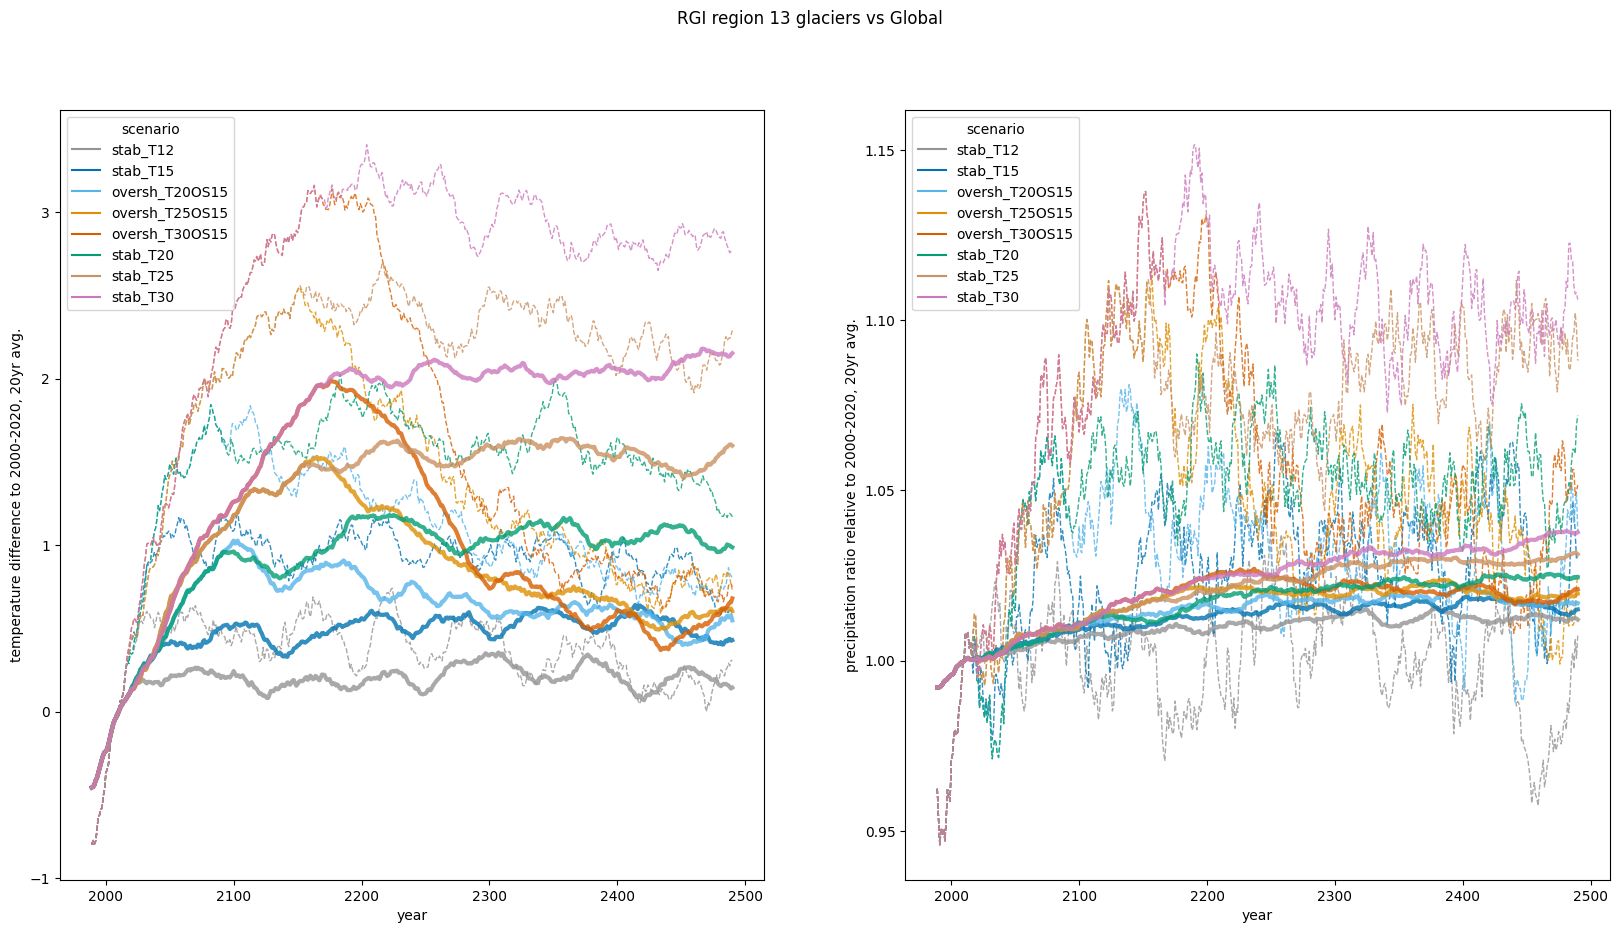

In [18]:
rgi_reg = '13'

pd_clim_glob = pd_clim_glob_rgi_reg.loc[pd_clim_glob_rgi_reg.region=='global']
pd_clim_glob.loc[:,'temp_rel_2000_2020_20yr_avg'] = (pd_clim_glob['temp_20yr_avg'] - pd_clim_glob.loc[pd_clim_glob.year==2010]['temp_20yr_avg'].iloc[0]).values
pd_clim_glob.loc[:,'precip_rel_2000_2020_20yr_avg'] = (pd_clim_glob['precip_20yr_avg']/pd_clim_glob.loc[pd_clim_glob.year==2010]['precip_20yr_avg'].iloc[0]).values

pd_clim_glob_rgi_reg_sel = pd_clim_glob_rgi_reg.loc[pd_clim_glob_rgi_reg.region==f'RGI{rgi_reg}_glacier']
assert np.all(pd_clim_glob_rgi_reg_sel.loc[pd_clim_glob_rgi_reg_sel.year==2010][['precip','temp']].std() < 1e-2)
pd_clim_glob_rgi_reg_sel.loc[:,'temp_rel_2000_2020_20yr_avg'] = pd_clim_glob_rgi_reg_sel['temp_20yr_avg'] - pd_clim_glob_rgi_reg_sel.loc[pd_clim_glob_rgi_reg_sel.year==2010]['temp_20yr_avg'].iloc[0]
pd_clim_glob_rgi_reg_sel.loc[:,'precip_rel_2000_2020_20yr_avg'] = pd_clim_glob_rgi_reg_sel['precip_20yr_avg']/pd_clim_glob_rgi_reg_sel.loc[pd_clim_glob_rgi_reg_sel.year==2010]['precip_20yr_avg'].iloc[0]

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.lineplot(data=pd_clim_glob_rgi_reg_sel,
             y='temp_rel_2000_2020_20yr_avg', x='year', hue='scenario',
             hue_order=scenarios,palette=palette,
             alpha = 0.8, ls= '--', lw=1);

sns.lineplot(data=pd_clim_glob,
             y='temp_rel_2000_2020_20yr_avg', x='year', hue='scenario', alpha = 0.8,
             hue_order=scenarios,palette=palette,
             lw=3, legend=False);
plt.ylabel('temperature difference to 2000-2020, 20yr avg.')
plt.subplot(1,2,2)
sns.lineplot(data=pd_clim_glob_rgi_reg_sel,
             y='precip_rel_2000_2020_20yr_avg', x='year', hue='scenario', 
             hue_order=scenarios,palette=palette,
             alpha = 0.8, ls= '--', lw=1);

sns.lineplot(data=pd_clim_glob,
             y='precip_rel_2000_2020_20yr_avg', x='year', hue='scenario', 
             hue_order=scenarios,palette=palette,
             alpha = 0.8, lw=3, legend=False);

plt.ylabel('precipitation ratio relative to 2000-2020, 20yr avg.')

plt.suptitle(f'RGI region {rgi_reg} glaciers vs Global')

/tmp/ipykernel_1744751/1356199755.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_clim_glob.loc[:,'temp_rel_2000_2020_20yr_avg'] = (pd_clim_glob['temp_20yr_avg'] - pd_clim_glob.loc[pd_clim_glob.year==2010]['temp_20yr_avg'].iloc[0]).values
/tmp/ipykernel_1744751/1356199755.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pd_clim_glob.loc[:,'precip_rel_2000_2020_20yr_avg'] = (pd_clim_glob['precip_20yr_avg']/pd_clim_glob.loc[pd_clim_glob.year==2010]['precip_20yr_avg'].iloc[0]).values
/tmp/ipykernel_1

Text(0.5, 0.98, 'RGI region 14 glaciers vs Global')

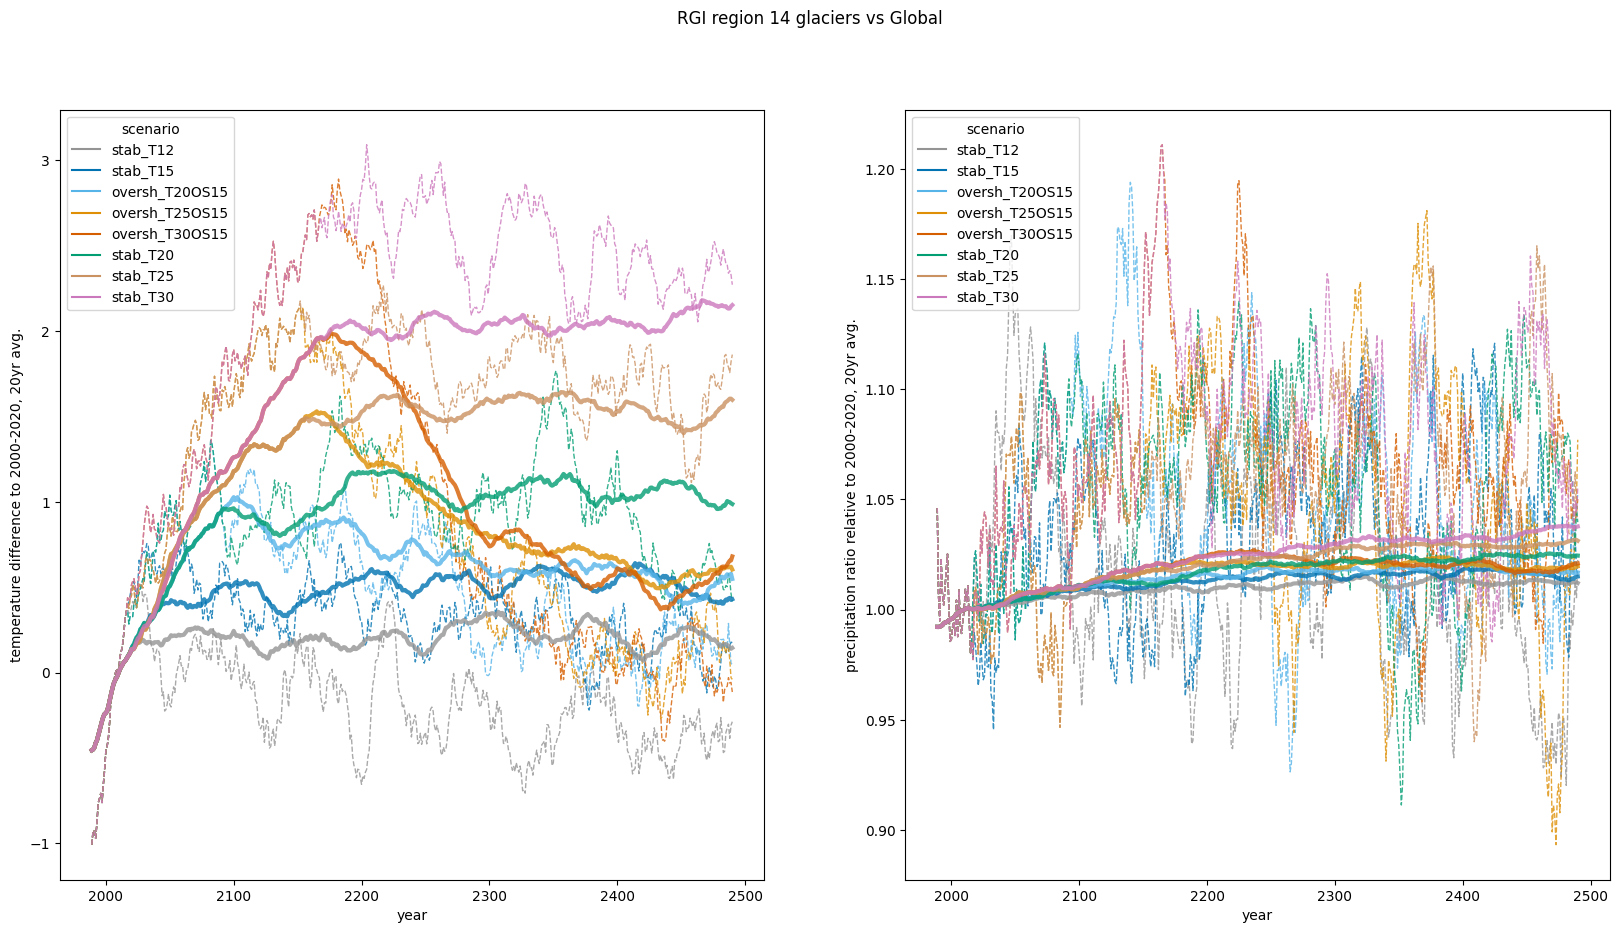

In [19]:
rgi_reg = '14'

pd_clim_glob = pd_clim_glob_rgi_reg.loc[pd_clim_glob_rgi_reg.region=='global']
pd_clim_glob.loc[:,'temp_rel_2000_2020_20yr_avg'] = (pd_clim_glob['temp_20yr_avg'] - pd_clim_glob.loc[pd_clim_glob.year==2010]['temp_20yr_avg'].iloc[0]).values
pd_clim_glob.loc[:,'precip_rel_2000_2020_20yr_avg'] = (pd_clim_glob['precip_20yr_avg']/pd_clim_glob.loc[pd_clim_glob.year==2010]['precip_20yr_avg'].iloc[0]).values

pd_clim_glob_rgi_reg_sel = pd_clim_glob_rgi_reg.loc[pd_clim_glob_rgi_reg.region==f'RGI{rgi_reg}_glacier']
assert np.all(pd_clim_glob_rgi_reg_sel.loc[pd_clim_glob_rgi_reg_sel.year==2010][['precip','temp']].std() < 1e-2)
pd_clim_glob_rgi_reg_sel.loc[:,'temp_rel_2000_2020_20yr_avg'] = pd_clim_glob_rgi_reg_sel['temp_20yr_avg'] - pd_clim_glob_rgi_reg_sel.loc[pd_clim_glob_rgi_reg_sel.year==2010]['temp_20yr_avg'].iloc[0]
pd_clim_glob_rgi_reg_sel.loc[:,'precip_rel_2000_2020_20yr_avg'] = pd_clim_glob_rgi_reg_sel['precip_20yr_avg']/pd_clim_glob_rgi_reg_sel.loc[pd_clim_glob_rgi_reg_sel.year==2010]['precip_20yr_avg'].iloc[0]

plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
sns.lineplot(data=pd_clim_glob_rgi_reg_sel,
             y='temp_rel_2000_2020_20yr_avg', x='year', hue='scenario',
             hue_order=scenarios,palette=palette,
             alpha = 0.8, ls= '--', lw=1);

sns.lineplot(data=pd_clim_glob,
             y='temp_rel_2000_2020_20yr_avg', x='year', hue='scenario', alpha = 0.8,
             hue_order=scenarios,palette=palette,
             lw=3, legend=False);
plt.ylabel('temperature difference to 2000-2020, 20yr avg.')
plt.subplot(1,2,2)
sns.lineplot(data=pd_clim_glob_rgi_reg_sel,
             y='precip_rel_2000_2020_20yr_avg', x='year', hue='scenario', 
             hue_order=scenarios,palette=palette,
             alpha = 0.8, ls= '--', lw=1);

sns.lineplot(data=pd_clim_glob,
             y='precip_rel_2000_2020_20yr_avg', x='year', hue='scenario', 
             hue_order=scenarios,palette=palette,
             alpha = 0.8, lw=3, legend=False);

plt.ylabel('precipitation ratio relative to 2000-2020, 20yr avg.')

plt.suptitle(f'RGI region {rgi_reg} glaciers vs Global')

#### now extract local "glacier" climate of the basins
- for the basins, it is a bit more problematic to use the masking, as often on one gridpoint there are several basins at the coarse resolution of ~2.5°
- so for the basins, I first wanted to do the slow loop over every glacier, but then decided to rather loop over every basin and do the masking
    - I use the slow loop method over every glacier for the Rhine, just to test if the same values come out!

In [21]:
load = True
import geopandas as gpd
#pd_basin_num = gpd.read_file('/home/www/fmaussion/misc/magicc/basins_shape/glacier_basins.shp')
# also the driest months of every basin is added
pd_basin_num = pd.read_csv('/home/www/lschuster/provide/gfdl-esm2m_oversh_stab_uni_bern/analysis_notebooks/schuster_el_al_phd_paper_2_overshoot_glaciers/basin_driest_months.csv')
def func_sel_months(basin_id):
    _sel = pd_basin_num.loc[pd_basin_num.MRBID==int(basin_id)]
    last_month_of_3m_driest = int(_sel['last_3m_driest_month_seasonal_avg'].values)
    return last_month_of_3m_driest
if load:
    ## get a mask for every glacier basin -> this is a bit more accurate, as the same gridpoint can be used (with a different "weight") for 
    # different basins (in case of RGI regions, it probably does not matter, but basins are nearer together)
    weight_glacier_basin_id_dict = {}
    ds_ref = xr.open_dataset('../gfdl_esm2m/oversh_T20OS15/' + 'atmos_month_1861.nc')
    ds_ref = ds_ref.isel(lat=slice(1,-1))
    max_lat = np.unique((ds_ref.lat.values[1:]-ds_ref.lat.values[:-1])/2)[0]
    max_lon = np.unique(ds_ref.lon.values[1:] - ds_ref.lon.values[:-1])[0]/2

    ds_ref.coords['lon'] = np.where(ds_ref.lon.values < 0,
                                          ds_ref.lon.values + 360,
                                          ds_ref.lon.values)
    ds_ref = ds_ref.sortby(ds_ref.lon)
    ds_ref.lon.attrs['units'] = 'degrees_onlypositive'
    ds_ref = ds_ref.drop_vars(['time_bnds','t_ref','precip']).drop_dims('time')

    for basin in pd_basin_num['RIVER_BASI']:

        # get the dataset where coordinates of glaciers are stored
        frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
        odf = pd.read_hdf(frgi, index_col=0)

        nx, ny = ds_ref.dims['lon'], ds_ref.dims['lat']
        # just make them into 0-> 360 scheme
        cenlon_for_bins = np.where(odf['CenLon'] < 0,
                                   odf['CenLon']+360, odf['CenLon'])

        # Nearest neighbor lookup
        lon_bins = np.linspace(ds_ref.lon.data[0] - max_lon, ds_ref.lon.data[-1] + max_lon, nx+1)
        lat_bins = np.linspace(ds_ref.lat.data[0] - max_lat, ds_ref.lat.data[-1] + max_lat, ny+1)

        odf['lon_id'] = np.digitize(cenlon_for_bins, lon_bins)-1
        odf['lat_id'] = np.digitize(odf['CenLat'], lat_bins)-1
        odf['lon_val'] = ds_ref.lon.data[odf.lon_id]
        odf['lat_val'] = ds_ref.lat.data[odf.lat_id]
        # Use unique grid points as index and compute the area per location
        odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]

        basin_idx = pd_basin_num[pd_basin_num['RIVER_BASI'] == basin]['MRBID'].values[0]
        f = open('/home/www/fmaussion/misc/magicc/rgi_ids_per_basin.json')
        rgis_basin = json.load(f)[str(basin_idx)]
        odf['basin_Area'] = 0
        odf.loc[rgis_basin,'basin_Area'] = odf.loc[rgis_basin,'Area'] #basin_idx
        print(odf['basin_Area'].sum())
        mdf = odf.drop_duplicates(subset='unique_id').set_index('unique_id')
        mdf['basin_Area'] = odf.groupby('unique_id').sum()['basin_Area']
        #print('Total number of glaciers: {} and number of GCM gridpoints with glaciers in them: {}'.format(len(odf), len(mdf)))
        print(basin, len(rgis_basin))
        # this is the mask that we need to remove all non-glacierized gridpoints for one basin 
        mask_basin = np.full((ny, nx), np.NaN)
        mask_basin[mdf['lat_id'], mdf['lon_id']] = mdf['basin_Area'] # 1
        ds_ref['glacier_mask_basin'] = (('lat', 'lon'), np.isfinite(mask_basin))


        # check the distance to the gridpoints-> it should never be larger than 
        diff_lon = ds_ref.lon.data[odf.lon_id] - odf.CenLon
        # if the distance is 360 -> it is the same as 0,
        diff_lon = np.where(np.abs(diff_lon - 360) < 170, diff_lon-360, diff_lon)
        odf['ll_dist_to_point'] = ((diff_lon)**2 + (ds_ref.lat.data[odf.lat_id] - odf.CenLat)**2)**0.5
        assert odf['ll_dist_to_point'].max() < (max_lon**2 + max_lat**2)**0.5
        # just select the glacier_mask variable:

        ds_ref['glacier_area_basin'] = (('lat', 'lon'), mask_basin)
        ds_ref['weight_glacier_basin'] = (('lat', 'lon'), mask_basin / np.nansum(mask_basin))
        
        np.testing.assert_allclose(ds_ref['weight_glacier_basin'].sum(),1)
        weight_glacier_basin_id_dict[basin_idx] = ds_ref['weight_glacier_basin']
        
    l_pd_clim_glob_basin = []
    for basin_id in weight_glacier_basin_id_dict.keys():
        sel_month = func_sel_months(basin_id)

        weight_glacier_basin = weight_glacier_basin_id_dict[basin_id]
        for scenario in ['stab_T12','stab_T15','oversh_T20OS15','oversh_T25OS15',
                         'oversh_T30OS15','stab_T20','stab_T25','stab_T30']:

            weight_sel = weight_glacier_basin #.sum(dim='lon')
            np.testing.assert_allclose(weight_sel.sum(),1)
            _pd_clim_glob_basin = pd.DataFrame(index=np.arange(1979,2500,1))

            dg_tas = xr.open_dataset(f'../gfdl_esm2m/{scenario}/scenario_tas_annual.nc').t_ref
            global_dtas = (dg_tas * weight_sel).sum(dim='lon').sum(dim='lat')
            dg_precip = xr.open_dataset(f'../gfdl_esm2m/{scenario}/scenario_precip_annual.nc').precip
            global_dprecip = (dg_precip * weight_sel).sum(dim='lon').sum(dim='lat')
            _pd_clim_glob_basin.loc[global_dtas.year,'temp'] = global_dtas.values
            _pd_clim_glob_basin['temp_20yr_avg'] = _pd_clim_glob_basin['temp'].rolling(20, center=True).mean()
            _pd_clim_glob_basin['temp_21yr_avg'] = _pd_clim_glob_basin['temp'].rolling(21, center=True).mean()

            _pd_clim_glob_basin.loc[global_dtas.year,'precip'] = global_dprecip.values
            _pd_clim_glob_basin['precip_20yr_avg'] = _pd_clim_glob_basin['precip'].rolling(20, center=True).mean()
            _pd_clim_glob_basin['precip_21yr_avg'] = _pd_clim_glob_basin['precip'].rolling(21, center=True).mean()

            # need to load here monthly precipitation data
            dg_precip_m = xr.open_dataset(f'../gfdl_esm2m/{scenario}/scenario_precip_monthly.nc').precip
            global_dprecip_m = (dg_precip_m * weight_sel).sum(dim='lon').sum(dim='lat')
            ### TODO 
            # need todo the 3 month rolling average and then select the driest month according to the basin statistics
            global_dprecip_m_roll = global_dprecip_m.rolling(time=3).mean()
            # only select the sel_month (that corresponds to average precipitation over these last 3 months
            precip_roll_3m_avg = global_dprecip_m_roll.where(global_dprecip_m_roll['time.month'] == sel_month).dropna(dim='time')
            # let's convert the time framework into a year framework, (we only have one entry per year anyways ...
            precip_roll_3m_avg = precip_roll_3m_avg.groupby('time.year').mean()
            ### alternative ...  or need to just select the three months and just do the average
            _pd_clim_glob_basin.loc[precip_roll_3m_avg.year, 'precip_3mdriest_avg_per_day'] = precip_roll_3m_avg.values
            _pd_clim_glob_basin.loc[precip_roll_3m_avg.year, 'precip_3mdriest_avg_per_day_51yr_avg']  = precip_roll_3m_avg.rolling(year=51,center=True, min_periods=50).mean().values
            _pd_clim_glob_basin['month_precip_3mdriest_past_W5E5'] = sel_month
            _pd_clim_glob_basin.loc[global_dtas.year,'region'] = f'basin_{basin_id}_glacier'
            _pd_clim_glob_basin.loc[global_dtas.year,'scenario'] = scenario
            _pd_clim_glob_basin.loc[global_dtas.year,'year'] = global_dtas.year.values
            l_pd_clim_glob_basin.append(_pd_clim_glob_basin)
    pd_clim_basin_glac = pd.concat(l_pd_clim_glob_basin).reset_index()
    pd_clim_basin_glac['year'] = pd_clim_basin_glac.year.astype(int).values
    pd_clim_basin_glac = pd_clim_basin_glac.drop(columns='index')
    pd_clim_basin_glac.to_csv('../gfdl_esm2m/annual_basin_glacier_mask_temp_precip_timeseries_oversh_stab.csv')
else:
    pd_clim_basin_glac = pd.read_csv('../gfdl_esm2m/annual_basin_glacier_mask_temp_precip_timeseries_oversh_stab.csv', index_col=['Unnamed: 0'])


171.94099999999997
INDIGIRKA 331
763.493
OB 1609
10528.496
BRAHMAPUTRA 11508
7906.081000000001
GANGES 6552
27206.546000000002
INDUS 23424
47.619
IRRAWADDY 144
1265.39
SALWEEN 2134
196.53500000000003
KAMCHATKA 135
171.33100000000002
MEKONG 405
1710.2359999999999
YANGTZE 1633
177.38299999999998
YELLOW RIVER 287
12558.725999999999
ARAL SEA 16211
381.093
CHUY (also SHU) 719
319.702
HAR US NUUR 567
2328.337
LAKE BALKHASH 3142
68.854
TALAS 174
26142.022000000004
TARIM HE (also TALIMU HE) 20791
48.258
UVS NUUR (also UBSU-NUR) 54
507.86199999999997
YSYK-KOL (also ISSYK-KUL) 807
1402.174
AMAZON (also AMAZONAS) 1557
33.841
CHICO 109
1301.0140000000001
COLORADO 1746
46.756
MAGDALENA 30
47.725
NEGRO (Atlantic Ocean) 194
3011.749
SANTA CRUZ 462
153.92000000000002
AISEN 404
30.208999999999996
AZOPARDO 88
2206.693
BAKER 1957
74.65899999999999
BIOBIO 138
71.70500000000001
CISNES 180
35.19799999999999
COPIAPO 71
33.835
HUASCO 89
30.628000000000004
MAJES 64
34.873
OCONA 34
349.118
PALENA (also CORCOVADO

In [66]:
pd_clim_basin_glac.loc[pd_clim_basin_glac.region=='basin_6243_glacier']

,temp,temp_20yr_avg,precip,precip_20yr_avg,precip_3mdriest_avg_per_day,precip_3mdriest_avg_per_day_51yr_avg,month_precip_3mdriest_past_W5E5,region,scenario,year
300096,280.538819,NaN,1398.628140,NaN,4.188922,NaN,8,basin_6243_glacier,stab_T12,1979
300097,280.479665,NaN,1112.408845,NaN,4.066972,NaN,8,basin_6243_glacier,stab_T12,1980
300098,281.651710,NaN,1171.458941,NaN,3.485658,NaN,8,basin_6243_glacier,stab_T12,1981
300099,281.371820,NaN,1373.927632,NaN,4.614467,NaN,8,basin_6243_glacier,stab_T12,1982
300100,281.265148,NaN,1332.538615,NaN,4.167353,NaN,8,basin_6243_glacier,stab_T12,1983
...,...,...,...,...,...,...,...,...,...,...
304259,283.627994,NaN,1428.055580,NaN,5.057542,NaN,8,basin_6243_glacier,stab_T30,2495
304260,283.802392,NaN,1320.756844,NaN,4.219780,NaN,8,basin_6243_glacier,stab_T30,2496
304261,283.877752,NaN,1447.315518,NaN,3.589228,NaN,8,basin_6243_glacier,stab_T30,2497
304262,283.753601,NaN,1232.422998,NaN,3.899659,NaN,8,basin_6243_glacier,stab_T30,2498


### Also extract provide-region climate:

In [22]:
load = True
if load:
    ## get a mask for every glacier basin -> this is a bit more accurate, as the same gridpoint can be used (with a different "weight") for 
    # different basins (in case of RGI regions, it probably does not matter, but basins are nearer together)
    weight_glacier_basin_id_dict = {}
    ds_ref = xr.open_dataset('../gfdl_esm2m/oversh_T20OS15/' + 'atmos_month_1861.nc')
    ds_ref = ds_ref.isel(lat=slice(1,-1))
    max_lat = np.unique((ds_ref.lat.values[1:]-ds_ref.lat.values[:-1])/2)[0]
    max_lon = np.unique(ds_ref.lon.values[1:] - ds_ref.lon.values[:-1])[0]/2

    ds_ref.coords['lon'] = np.where(ds_ref.lon.values < 0,
                                          ds_ref.lon.values + 360,
                                          ds_ref.lon.values)
    ds_ref = ds_ref.sortby(ds_ref.lon)
    ds_ref.lon.attrs['units'] = 'degrees_onlypositive'
    ds_ref = ds_ref.drop_vars(['time_bnds','t_ref','precip']).drop_dims('time')

    #for basin in pd_basin_num['RIVER_BASI']:
    for pi in np.arange(1,14,1):
        f = open('/home/www/lschuster/provide/provide_glacier_regions/rgi_ids_per_provide_region.json')
        if pi<10:
            Preg = f'P0{pi}'
        else:
            Preg = f'P{pi}'
        rgis_basin = json.load(f)[Preg]
        # remove connectivity level 2 glaciers only important for P03 (Greenland)
        rgis_basin = odf.loc[rgis_basin].loc[odf.loc[rgis_basin].Connect <2].index.values
        rgis_basin = list(set(rgis_basin))
        
        # get the dataset where coordinates of glaciers are stored
        frgi = utils.file_downloader('https://cluster.klima.uni-bremen.de/~oggm/rgi/rgi62_stats.h5')
        odf = pd.read_hdf(frgi, index_col=0)

        nx, ny = ds_ref.dims['lon'], ds_ref.dims['lat']
        # just make them into 0-> 360 scheme
        cenlon_for_bins = np.where(odf['CenLon'] < 0,
                                   odf['CenLon']+360, odf['CenLon'])

        # Nearest neighbor lookup
        lon_bins = np.linspace(ds_ref.lon.data[0] - max_lon, ds_ref.lon.data[-1] + max_lon, nx+1)
        lat_bins = np.linspace(ds_ref.lat.data[0] - max_lat, ds_ref.lat.data[-1] + max_lat, ny+1)

        odf['lon_id'] = np.digitize(cenlon_for_bins, lon_bins)-1
        odf['lat_id'] = np.digitize(odf['CenLat'], lat_bins)-1
        odf['lon_val'] = ds_ref.lon.data[odf.lon_id]
        odf['lat_val'] = ds_ref.lat.data[odf.lat_id]
        # Use unique grid points as index and compute the area per location
        odf['unique_id'] = ['{:03d}_{:03d}'.format(lon, lat) for (lon, lat) in zip(odf['lon_id'], odf['lat_id'])]

        odf['basin_Area'] = 0
        odf.loc[rgis_basin,'basin_Area'] = odf.loc[rgis_basin,'Area'] #basin_idx
        print(odf['basin_Area'].sum())
        mdf = odf.drop_duplicates(subset='unique_id').set_index('unique_id')
        mdf['basin_Area'] = odf.groupby('unique_id').sum()['basin_Area']
        #print('Total number of glaciers: {} and number of GCM gridpoints with glaciers in them: {}'.format(len(odf), len(mdf)))
        print(Preg, len(rgis_basin))
        # this is the mask that we need to remove all non-glacierized gridpoints for one basin 
        mask_basin = np.full((ny, nx), np.NaN)
        mask_basin[mdf['lat_id'], mdf['lon_id']] = mdf['basin_Area'] # 1
        ds_ref['glacier_mask_basin'] = (('lat', 'lon'), np.isfinite(mask_basin))


        # check the distance to the gridpoints-> it should never be larger than 
        diff_lon = ds_ref.lon.data[odf.lon_id] - odf.CenLon
        # if the distance is 360 -> it is the same as 0,
        diff_lon = np.where(np.abs(diff_lon - 360) < 170, diff_lon-360, diff_lon)
        odf['ll_dist_to_point'] = ((diff_lon)**2 + (ds_ref.lat.data[odf.lat_id] - odf.CenLat)**2)**0.5
        assert odf['ll_dist_to_point'].max() < (max_lon**2 + max_lat**2)**0.5
        # just select the glacier_mask variable:

        ds_ref['glacier_area_basin'] = (('lat', 'lon'), mask_basin)
        ds_ref['weight_glacier_basin'] = (('lat', 'lon'), mask_basin / np.nansum(mask_basin))
        
        np.testing.assert_allclose(ds_ref['weight_glacier_basin'].sum(),1)
        weight_glacier_basin_id_dict[Preg] = ds_ref['weight_glacier_basin']
        
    l_pd_clim_glob_basin = []
    for Preg in weight_glacier_basin_id_dict.keys():
        weight_glacier_basin = weight_glacier_basin_id_dict[Preg]
        for scenario in ['stab_T12','stab_T15','oversh_T20OS15','oversh_T25OS15',
                         'oversh_T30OS15','stab_T20','stab_T25','stab_T30']:

            weight_sel = weight_glacier_basin #.sum(dim='lon')
            np.testing.assert_allclose(weight_sel.sum(),1)
            _pd_clim_glob_basin = pd.DataFrame(index=np.arange(1979,2500,1))

            dg_tas = xr.open_dataset(f'../gfdl_esm2m/{scenario}/scenario_tas_annual.nc').t_ref
            global_dtas = (dg_tas * weight_sel).sum(dim='lon').sum(dim='lat')
            dg_precip = xr.open_dataset(f'../gfdl_esm2m/{scenario}/scenario_precip_annual.nc').precip
            global_dprecip = (dg_precip * weight_sel).sum(dim='lon').sum(dim='lat')
            _pd_clim_glob_basin.loc[global_dtas.year,'temp'] = global_dtas.values
            _pd_clim_glob_basin['temp_20yr_avg'] = _pd_clim_glob_basin['temp'].rolling(20, center=True).mean()
            _pd_clim_glob_basin['temp_21yr_avg'] = _pd_clim_glob_basin['temp'].rolling(21, center=True).mean()
            _pd_clim_glob_basin.loc[global_dtas.year,'precip'] = global_dprecip.values
            _pd_clim_glob_basin['precip_20yr_avg'] = _pd_clim_glob_basin['precip'].rolling(20, center=True).mean()
            _pd_clim_glob_basin['precip_21yr_avg'] = _pd_clim_glob_basin['precip'].rolling(21, center=True).mean()

            _pd_clim_glob_basin.loc[global_dtas.year,'region'] = f'provide_reg_{Preg}_glacier'
            _pd_clim_glob_basin.loc[global_dtas.year,'scenario'] = scenario
            _pd_clim_glob_basin.loc[global_dtas.year,'year'] = global_dtas.year.values
            l_pd_clim_glob_basin.append(_pd_clim_glob_basin)
    pd_clim_basin_glac = pd.concat(l_pd_clim_glob_basin).reset_index()
    pd_clim_basin_glac['year'] = pd_clim_basin_glac.year.astype(int).values
    pd_clim_basin_glac = pd_clim_basin_glac.drop(columns='index')
    pd_clim_basin_glac.to_csv('../gfdl_esm2m/annual_provide_reg_glacier_mask_temp_precip_timeseries_oversh_stab.csv')
else:
    pd_clim_provide_reg_glac = pd.read_csv('../gfdl_esm2m/annual_provide_reg_glacier_mask_temp_precip_timeseries_oversh_stab.csv', index_col=['Unnamed: 0'])


101231.085
P01 45942
145998.87
P02 11971
89717.06599999999
P03 19306
14130.275
P04 4033
85463.881
P05 2840
1194.942
P06 2218
2092.146
P07 3927
1306.992
P08 1888
98804.39899999999
P09 98286
2334.4930000000004
P10 2898
29429.08
P11 15908
1161.801
P12 3537
132867.21899999998
P13 2752


#### Get both together 

In [4]:
path

'../gfdl_esm2m'

In [23]:
pd_clim_basin_glac = pd.read_csv('../gfdl_esm2m/annual_basin_glacier_mask_temp_precip_timeseries_oversh_stab.csv', index_col=['Unnamed: 0'])
pd_clim_provide_reg_glac = pd.read_csv('../gfdl_esm2m/annual_provide_reg_glacier_mask_temp_precip_timeseries_oversh_stab.csv', index_col=['Unnamed: 0'])

pd_clim_glob_rgi_reg = pd.read_csv('../gfdl_esm2m/annual_glob_glacier_rgi_reg_temp_precip_timeseries_oversh_stab.csv', index_col='Unnamed: 0')
pd_clim_all = pd.concat([pd_clim_glob_rgi_reg, pd_clim_basin_glac, pd_clim_provide_reg_glac])
pd_clim_all.to_csv('../data/annual_glob_rgi_reg_basin_temp_precip_timeseries_oversh_stab.csv')

### Some tests:

**manually extract climate from Aletschglacier from the raw files, compare it then to the aggregated basin/RGI/provide region files**
(should be at least quite similar)

In [5]:
lon_aletsch, lat_aletsch = odf.loc['RGI60-11.01450'][['CenLon', 'CenLat']]

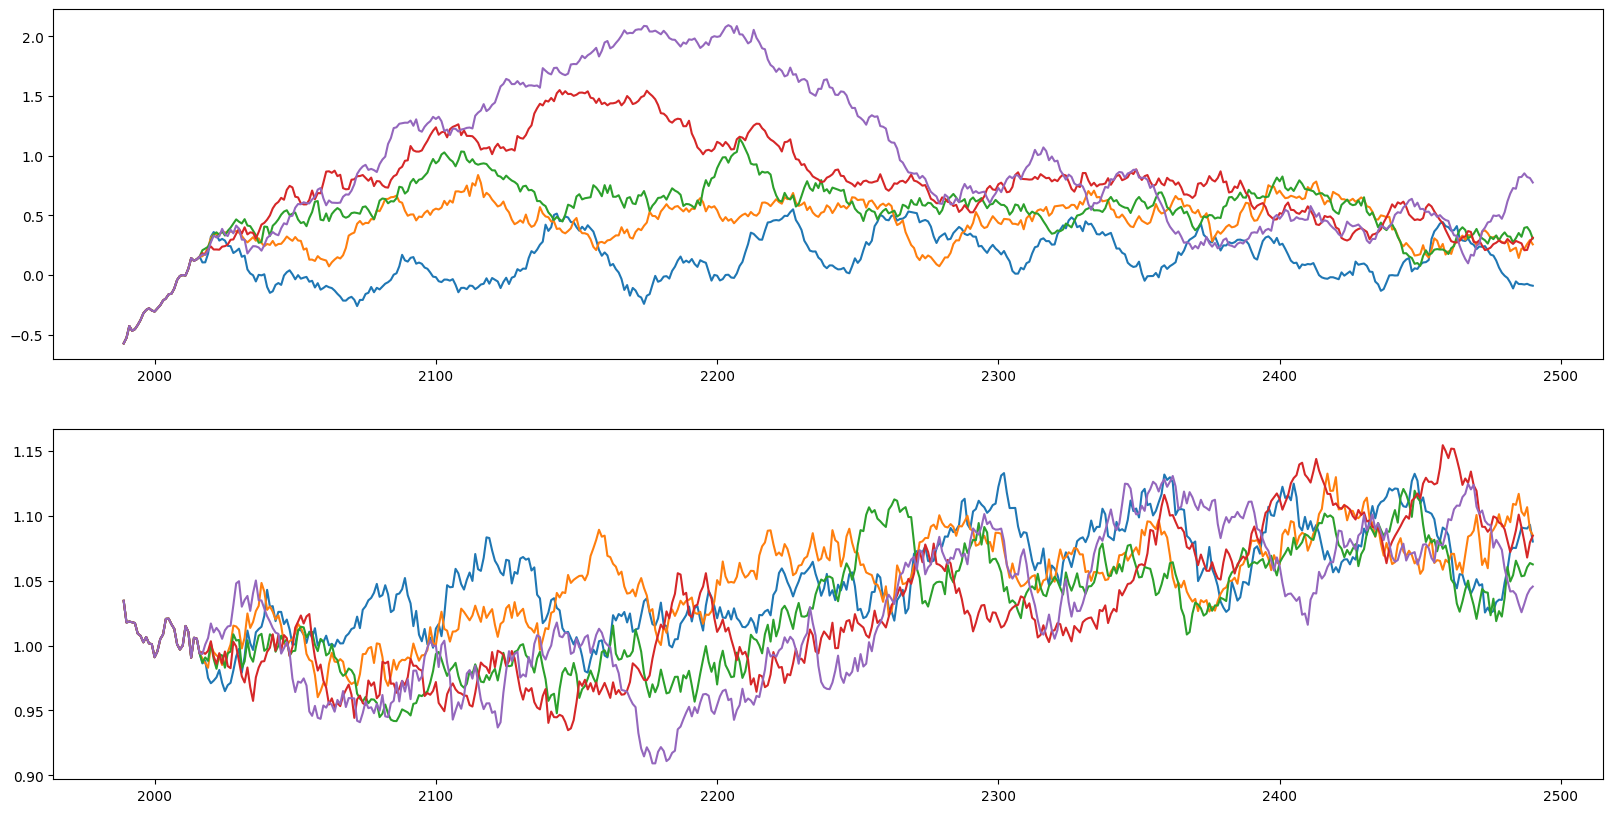

In [7]:
# just open any file to check the format
path = '../gfdl_esm2m'
with xr.open_mfdataset(path + '/oversh_T20OS15/' + 'atmos_month_20*.nc') as ds_ref:
    ds = ds_ref.sel(lon=lon_aletsch, lat=lat_aletsch, method='nearest').load()
# flattening file test was done at the beginning of notebook
dg_tas_aletsch = xr.open_dataset(f'{path}/oversh_T20OS15/scenario_tas_annual.nc').sel(lon=lon_aletsch, lat=lat_aletsch, method='nearest')
# dg_pr = xr.open_dataset(f'{path}/oversh_T20OS15/scenario_p.nc')
np.testing.assert_allclose(dg_tas_aletsch.sel(year=slice(2000,2099)).t_ref,
                           ds.t_ref.load().groupby('time.year').mean(), rtol=1e-5)



basin = 'RHONE'
import geopandas as gpd
pd_basin_num = gpd.read_file('/home/www/fmaussion/misc/magicc/basins_shape/glacier_basins.shp')
basin_idx = pd_basin_num[pd_basin_num['RIVER_BASI'] == basin]['MRBID'].values[0]

pd_clim_all = pd.read_csv('../data/annual_glob_rgi_reg_basin_temp_precip_timeseries_oversh_stab.csv', index_col = 'Unnamed: 0')
clim_rgi_11 = pd_clim_all.loc[pd_clim_all.region == 'RGI11_glacier']
clim_basin_rhone = pd_clim_all.loc[pd_clim_all.region == f'basin_{basin_idx}_glacier']  # this is 
scenarios = ['stab_T12','stab_T15', 'oversh_T20OS15',
                     'oversh_T25OS15',
                     'oversh_T30OS15']
fig, axs = plt.subplots(2,1, figsize=(20,10))
for scenario in scenarios:
    dg_tas_aletsch = xr.open_dataset(f'{path}/{scenario}/scenario_tas_annual.nc').sel(lon=lon_aletsch, lat=lat_aletsch, method='nearest')
    dg_precip_aletsch = xr.open_dataset(f'{path}/{scenario}/scenario_precip_annual.nc').sel(lon=lon_aletsch, lat=lat_aletsch, method='nearest')

    np.testing.assert_allclose(clim_rgi_11.loc[clim_rgi_11.scenario == scenario]['temp'].values,
                               dg_tas_aletsch.t_ref, rtol = 0.01)
    np.testing.assert_allclose(clim_basin_rhone.loc[clim_basin_rhone.scenario==scenario]['temp'].values,
                                dg_tas_aletsch.t_ref, rtol = 0.01)
    
    np.testing.assert_allclose(clim_rgi_11.loc[clim_rgi_11.scenario == scenario]['precip'].values,
                               dg_precip_aletsch.precip, rtol = 0.25) # more precip variability
    np.testing.assert_allclose(clim_basin_rhone.loc[clim_basin_rhone.scenario==scenario]['precip'].values,
                                dg_precip_aletsch.precip, rtol = 0.25) # more precip variability
    
    assert np.corrcoef(clim_rgi_11.loc[clim_rgi_11.scenario==scenario]['precip'].values,
                                dg_precip_aletsch.precip)[0][1] > 0.90
    assert np.corrcoef(clim_basin_rhone.loc[clim_basin_rhone.scenario==scenario]['precip'].values,
                                dg_precip_aletsch.precip)[0][1] > 0.90
    
    delta_t_aletsch = dg_tas_aletsch.t_ref -dg_tas_aletsch.t_ref.sel(year=slice(2000,2019)).mean()
    # do a visual check with the poster plot 
    axs[0].plot(delta_t_aletsch.to_dataframe().rolling(20, center=True).mean()['t_ref'])                    
    ratio_prcp_aletsch = dg_precip_aletsch.precip/dg_precip_aletsch.precip.sel(year=slice(2000,2019)).mean()
    axs[1].plot(ratio_prcp_aletsch.to_dataframe().rolling(20, center=True).mean()['precip'])   
# ok, looks good!!! 

**this test below uses another method to extract the same information (it takes too long in large basins, but is good just as a test to compare it to the "masking" method above)**

In [8]:

pd_basin_num = gpd.read_file('/home/www/fmaussion/misc/magicc/basins_shape/glacier_basins.shp')

run_test = True
if run_test:
    l_pd_clim_glob_basin = []
    for scenario in ['stab_T12','stab_T15','oversh_T20OS15','oversh_T25OS15',
                     'oversh_T30OS15','stab_T20','stab_T25','stab_T30']:
        
        dg_tas = xr.open_dataset(f'{path}/{scenario}/scenario_tas_annual.nc').t_ref
        dg_precip = xr.open_dataset(f'{path}/{scenario}/scenario_precip_annual.nc').precip

        # now the same, but for every basin
        for basin in ['RHONE']:#, 'INDUS']: 
            basin_idx = pd_basin_num[pd_basin_num['RIVER_BASI'] == basin]['MRBID'].values[0]
            f = open('/home/www/fmaussion/misc/magicc/rgi_ids_per_basin.json')
            rgis_basin = json.load(f)[str(basin_idx)]

            _pd_clim_glob_basin = pd.DataFrame(index=np.arange(1979,2500,1))

            pd_stats_t = pd.DataFrame(index=odf.loc[rgis_basin].index)
            pd_stats_p = pd.DataFrame(index=odf.loc[rgis_basin].index)
            #for lat,lon in zip(odf.loc[rgis_basin].CenLat.values[:10], odf.loc[rgis_basin].CenLon.values[:10]):
            for rgi in odf.loc[rgis_basin].index:
                lon,lat = odf.loc[rgi].CenLon, odf.loc[rgi].CenLat
                temp = dg_tas.sel(lon=lon, lat=lat, method='nearest')
                precip = dg_precip.sel(lon=lon, lat=lat, method='nearest')
                pd_stats_t.loc[rgi,np.arange(1979,2500)] = temp
                pd_stats_p.loc[rgi,np.arange(1979,2500)] = precip
            temp_weight = pd_stats_t.dropna().apply(lambda x: np.average(x,
                                                                       weights=odf.loc[rgis_basin].Area.values,
                                                                       axis=0))
            precip_weight = pd_stats_p.dropna().apply(lambda x: np.average(x,
                                                                       weights=odf.loc[rgis_basin].Area.values,
                                                                       axis=0))

            _pd_clim_glob_basin.loc[temp_weight.index,'temp'] = temp_weight.values
            _pd_clim_glob_basin['temp_20yr_avg'] = _pd_clim_glob_basin['temp'].rolling(20, center=True).mean()
            _pd_clim_glob_basin.loc[temp_weight.index,'precip'] = precip_weight.values
            _pd_clim_glob_basin['precip_20yr_avg'] = _pd_clim_glob_basin['precip'].rolling(20, center=True).mean()
            _pd_clim_glob_basin.loc[temp_weight.index,'region'] = f'basin_{basin_idx}_glacier'
            _pd_clim_glob_basin.loc[temp_weight.index,'scenario'] = scenario
            _pd_clim_glob_basin.loc[temp_weight.index,'year'] = temp_weight.index
            l_pd_clim_glob_basin.append(_pd_clim_glob_basin)
    pd_clim_glob_basin_t = pd.concat(l_pd_clim_glob_basin).reset_index()
    pd_clim_glob_basin_t['year'] = pd_clim_glob_basin_t.year.astype(int).values

    # ok, the two methods are identical 
    np.testing.assert_allclose(pd_clim_glob_basin_t['temp'],
                               pd_clim_all.loc[pd_clim_all.region == 'basin_6243_glacier']['temp'])
    np.testing.assert_allclose(pd_clim_glob_basin_t['precip'],
                               pd_clim_all.loc[pd_clim_all.region == 'basin_6243_glacier']['precip'])